# Wuhan forecast 
## Author: Wentworth Liu
### Decicated for academic use only

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

# Replace with the latest version of "丁香园" web link
target = 'https://3g.dxy.cn/newh5/view/pneumonia?scene=2&clicktime=1579582238&enterid=1579582238&from=timeline&isappinstalled=0'
req = requests.get(url=target)
req.encoding = 'urf-8'
html = req.text
soup = BeautifulSoup(html, 'html.parser')

provinces = soup.find(id='getListByCountryTypeService1')
type(provinces)
data_regexp = re.compile("\[(.*?)\]")
a=re.findall(data_regexp,str(provinces))
a=a[0]
a=eval(a)
type(a)

data = {}
print('疫情：')
total = 0 
for province in a:
    try:
        
        name = province['provinceShortName']
        num = province['confirmedCount']
        if num == "":
            num = 0
        data['{}'.format(name)] = num
        total += num
    except AttributeError as e:
        continue
sorted_data={k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}
for k,v in sorted_data.items():
     print( k, '确诊', v, '例')
print('共计确诊：{} 例'.format(total))
# use when needed
# from datetime import datetime  
# from datetime import timedelta  
# datetime.today().date()
# daily_update = pd.DataFrame.from_dict(sorted_data,orient='index').rename(columns={0:str(datetime.today().date())})
# daily_update.to_csv('province_update.csv')

疫情：
湖北 确诊 2714 例
广东 确诊 188 例
浙江 确诊 173 例
河南 确诊 168 例
湖南 确诊 143 例
重庆 确诊 132 例
安徽 确诊 106 例
四川 确诊 90 例
山东 确诊 87 例
北京 确诊 80 例
江西 确诊 72 例
江苏 确诊 70 例
上海 确诊 66 例
福建 确诊 59 例
广西 确诊 51 例
海南 确诊 40 例
陕西 确诊 35 例
河北 确诊 33 例
黑龙江 确诊 30 例
辽宁 确诊 27 例
云南 确诊 26 例
天津 确诊 23 例
山西 确诊 20 例
甘肃 确诊 19 例
内蒙古 确诊 13 例
宁夏 确诊 11 例
新疆 确诊 10 例
贵州 确诊 9 例
香港 确诊 8 例
吉林 确诊 8 例
澳门 确诊 7 例
青海 确诊 6 例
台湾 确诊 5 例
共计确诊：4529 例


In [5]:
#use when saving new daily provincial data is needed
from datetime import datetime  
from datetime import timedelta  
datetime.today().date()
daily_update = pd.DataFrame.from_dict(sorted_data,orient='index').rename(columns={0:str(datetime.today().date())})
daily_update.to_csv('province_update_{}.csv'.format(str(datetime.today().date())), encoding='utf_8_sig')

In [3]:
# similarly, we can grab city level data
provinces = soup.find(id='getAreaStat')
type(provinces)
data_regexp = re.compile("\[(.*?)\]")
b=re.findall(data_regexp,str(provinces))
b=b[4]
b=eval(b)
type(b)

citydata = {}
print('疫情：')
for province in b:
    try:

        name = province['cityName']
        num = province['confirmedCount']
        if num == "":
            num = 0
        if name=='湘西自治州':
            citydata['湘西土家族苗族自治州'] = num
        else:
            citydata['{}市'.format(name)] = num
    except AttributeError as e:
        continue
sorted_citydata={k: v for k, v in sorted(citydata.items(), key=lambda item: item[1], reverse=True)}
for k,v in sorted_citydata.items():
     print( k, '确诊', v, '例')

疫情：
长沙市 确诊 24 例
常德市 确诊 19 例
岳阳市 确诊 17 例
怀化市 确诊 16 例
邵阳市 确诊 11 例
益阳市 确诊 10 例
娄底市 确诊 9 例
株洲市 确诊 7 例
郴州市 确诊 7 例
永州市 确诊 7 例
衡阳市 确诊 7 例
湘潭市 确诊 6 例
湘西土家族苗族自治州 确诊 3 例


## Forecast the development of disease

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



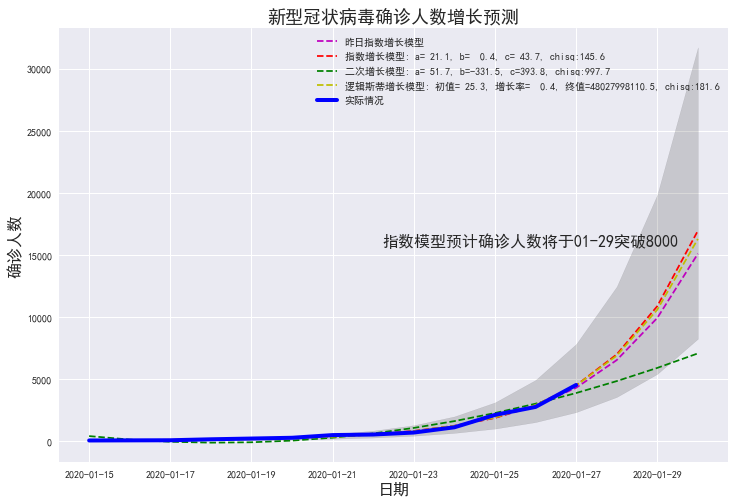

In [10]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
from scipy.stats import chisquare

df = pd.read_excel('virus.xlsx', sheet_name='Sheet1')
# Get the rapid growth part
rapid_growth=df.iloc[15:,:].reset_index(drop=True)

# Fitting model candidates
# Model 1
def expfunc(x, a, b, c):
    return a * np.exp(b * x) + c
exppopt, exppcov = curve_fit(expfunc, rapid_growth.index.values, rapid_growth.Confirmed)
expsigma = np.sqrt(np.diagonal(exppcov))

explagpopt, explagpcov = curve_fit(expfunc, rapid_growth.index.values[:-1], rapid_growth.Confirmed[:-1])

# Model 2
def ployfunc(x, a, b, c):
    return a * x**2 + b * x + c
polypopt, polypcov = curve_fit(ployfunc, rapid_growth.index.values, rapid_growth.Confirmed)
# Model 3
# https://www.zhihu.com/question/36714044
def logistic(x, a, r, c): 
    """Logistic growth model. 
    """ 
    y = c*a*np.exp(x*r)/(c+a*(np.exp(x*r)-1))
    return y 
logpopt, logpcov = curve_fit(logistic, rapid_growth.index.values, rapid_growth.Confirmed)

# Create n days ahead forecast
from datetime import timedelta 

n = 3
index = pd.date_range(rapid_growth.Date.iloc[-1]+timedelta(1), periods=n, freq='D')
columns=['expforecast','polyforecast','logforecast']
forecast = pd.DataFrame(index=index,columns=columns)

forecast=forecast.reset_index().rename(columns={'index':'Date'})
forecast.index=forecast.index.values+len(rapid_growth.index.values)
rapid_growth=pd.concat([rapid_growth,forecast])
# save the lastest date that contains actual value
confirmedid = rapid_growth[rapid_growth.Confirmed.notnull()]['Confirmed'].idxmax()
latest_date = rapid_growth.iloc[confirmedid]['Date']


# Plot
# -*- coding: utf-8 -*
from pylab import text
import matplotlib.pyplot as plt
from scipy.optimize import bisect
plt.style.use('seaborn')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

rapid_growth['expforecast']=expfunc(rapid_growth.index.values, *exppopt)
rapid_growth['explagforecast']=expfunc(rapid_growth.index.values, *explagpopt)
rapid_growth['polyforecast']=ployfunc(rapid_growth.index.values, *polypopt)
rapid_growth['logforecast']=logistic(rapid_growth.index.values, *logpopt)

expchi = chisquare(rapid_growth.Confirmed[:confirmedid], f_exp=rapid_growth.expforecast[:confirmedid])
explagchi = chisquare(rapid_growth.Confirmed[:confirmedid], f_exp=rapid_growth.explagforecast[:confirmedid])
polychi = chisquare(rapid_growth.Confirmed[:confirmedid], f_exp=rapid_growth.polyforecast[:confirmedid])
logchi = chisquare(rapid_growth.Confirmed[:confirmedid], f_exp=rapid_growth.logforecast[:confirmedid])
plt.figure(figsize=(12,8))

plt.plot(rapid_growth.Date, rapid_growth['explagforecast'], 'm--',label='昨日指数增长模型')
plt.plot(rapid_growth.Date, rapid_growth['expforecast'], 'r--',label='指数增长模型: a=%5.1f, b=%5.1f, c=%5.1f' % tuple(exppopt)+', chisq:{}'.format(round(expchi[0],1)))
# plotting the confidence intervals
bound_upper = expfunc(rapid_growth.index.values, *(exppopt + expsigma))
bound_lower = expfunc(rapid_growth.index.values, *(exppopt - expsigma))
plt.fill_between(rapid_growth.Date, bound_lower, bound_upper , color='black', alpha = 0.15)

# solve the equation of expfunc given specific value
threshold = 8000
def f(x):
    return expfunc(x,*exppopt) - threshold
predicted_date = rapid_growth.iloc[rapid_growth.index.values[math.ceil(bisect(f, 0, 19))]]['Date']
plt.figtext(.5, .5, "指数模型预计确诊人数将于{}突破{}".format(str(predicted_date)[5:10], threshold), fontsize=16)


rapid_growth.to_csv('predction_update_{}.csv'.format(str(datetime.today().date())))
# plt.figtext(.15, .8, "指数模型, 二次模型chisq:{}".format(round(expchi[0],1),round(polychi[0],1)))
plt.plot(rapid_growth.Date, rapid_growth['polyforecast'], 'g--',label='二次增长模型: a=%5.1f, b=%5.1f, c=%5.1f' % tuple(polypopt)+', chisq:{}'.format(round(polychi[0],1)))
plt.plot(rapid_growth.Date, rapid_growth['logforecast'], 'y--',label='逻辑斯蒂增长模型: 初值=%5.1f, 增长率=%5.1f, 终值=%5.1f' % tuple(logpopt)+', chisq:{}'.format(round(logchi[0],1)))
plt.plot(rapid_growth.Date, rapid_growth.Confirmed, 'b-', label='实际情况', linewidth=4)
plt.legend()
plt.ylabel("确诊人数", fontsize=16)
plt.xlabel("日期", fontsize=16)
plt.title("新型冠状病毒确诊人数增长预测", fontsize=18)
plt.savefig("新型冠状病毒确诊人数增长预测.png")


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Text(0.5, 0, '日期')

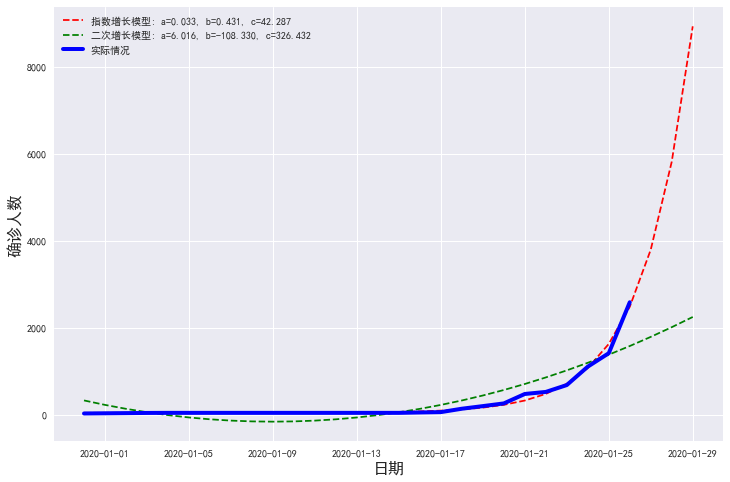

In [34]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
df = pd.read_excel('virus.xlsx', sheet_name='Sheet1')
# Get the rapid growth part
rapid_growth=df.reset_index(drop=True)

# Fitting model candidates
def expfunc(x, a, b, c):
    return a * np.exp(b * x) + c
exppopt, exppcov = curve_fit(expfunc, rapid_growth.index.values, rapid_growth.Confirmed)
def ployfunc(x, a, b, c):
    return a * x**2 + b * x + c
polypopt, polypcov = curve_fit(ployfunc, rapid_growth.index.values, rapid_growth.Confirmed)

# Create n days ahead forecast
from datetime import timedelta 

n = 3
index = pd.date_range(rapid_growth.Date.iloc[-1]+timedelta(1), periods=n, freq='D')
columns=['expforecast','polyforecast']
forecast = pd.DataFrame(index=index,columns=columns)

forecast=forecast.reset_index().rename(columns={'index':'Date'})
forecast.index=forecast.index.values+len(rapid_growth.index.values)
rapid_growth=pd.concat([rapid_growth,forecast])

# Plot
# -*- coding: utf-8 -*
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.figure(figsize=(12,8))
plt.plot(rapid_growth.Date, expfunc(rapid_growth.index.values, *exppopt), 'r--',label='指数增长模型: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(exppopt))
plt.plot(rapid_growth.Date, ployfunc(rapid_growth.index.values, *polypopt), 'g--',label='二次增长模型: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(polypopt))
plt.plot(rapid_growth.Date, rapid_growth.Confirmed, 'b-', label='实际情况', linewidth=4)
plt.legend()
plt.ylabel("确诊人数", fontsize=16)
plt.xlabel("日期", fontsize=16)

## National heat map, Hunan as an example:

In [72]:
# https://pyecharts.org/#/zh-cn/geography_charts?id=map%ef%bc%9a%e5%9c%b0%e5%9b%be
from pyecharts import options as opts
from pyecharts.charts import Map

# data structure example below:
# province_distribution = {'河南': 45.23, '北京': 37.56, '河北': 21, '辽宁': 12, '江西': 6, '上海': 20, '安徽': 10, '江苏': 16, '湖南': 9,'浙江': 13, '海南': 2, '广东': 22, '湖北': 8, '黑龙江': 11, '澳门': 1, '陕西': 11, '四川': 7, '内蒙古': 3, '重庆': 3,'云南': 6, '贵州': 2, '吉林': 3, '山西': 12, '山东': 11, '福建': 4, '青海': 1, '天津': 1,'其他': 1}
# provice = list(data.keys())
# values = list(data.values())

def map_base() -> Map:
    c = (
        Map()
        .add("新型冠状病毒确诊人数", [list(z) for z in zip(data.keys(), data.values())], "china")
        .set_global_opts(
            title_opts=opts.TitleOpts(title="全国确诊热力图 更新至{}".format(str(datetime.today().date())[5:10])),
            visualmap_opts=opts.VisualMapOpts(max_=200),
        )
    )
    return c
map=map_base()

map.render('全国确诊热力图.html')

'F:\\向菁\\virus\\全国确诊热力图.html'

## Provincial heat map, Hunan as an example:

In [16]:
# https://pyecharts.org/#/zh-cn/geography_charts?id=map%ef%bc%9a%e5%9c%b0%e5%9b%be
from pyecharts import options as opts
from pyecharts.charts import Map
def map_hunan() -> Map:
    c = (
        Map()
        .add("新型冠状病毒确诊人数", [list(z) for z in zip(citydata.keys(), citydata.values())], "湖南")
        .set_global_opts(
            title_opts=opts.TitleOpts(title="湖南确诊热力图 更新至{}".format(str(datetime.today().date())[5:10])),
            visualmap_opts=opts.VisualMapOpts(max_=22),
        )
    )
    return c
map=map_hunan()

map.render('湖南确诊热力图.html')

'F:\\向菁\\virus\\湖南确诊热力图.html'

In [11]:
rapid_growth

,Confirmed,Date,Suspected,expforecast,logforecast,polyforecast,explagforecast
0,41.0,2020-01-15,NaN,64.892552,25.262108,393.824176,49.480845
1,50.0,2020-01-16,NaN,76.763759,38.882345,114.032967,63.782827
2,58.0,2020-01-17,NaN,95.299038,59.846026,-62.324675,85.567505
3,136.0,2020-01-18,NaN,124.239364,92.112418,-135.248751,118.749773
4,196.0,2020-01-19,40.0,169.425760,141.775454,-104.739261,169.292769
5,258.0,2020-01-20,127.0,239.978191,218.214653,29.203796,246.279503
6,475.0,2020-01-21,260.0,350.136246,335.866565,266.580420,363.545152
7,522.0,2020-01-22,330.0,522.133114,516.951305,607.390609,542.163360
8,680.0,2020-01-23,450.0,790.682905,795.669110,1051.634366,814.233352
9,1103.0,2020-01-24,1056.0,1209.986993,1224.659508,1599.311688,1228.648442


### Epidemic model
- SIR model with Python
> https://www.youtube.com/watch?v=wEvZmBXgxO0
- The SIR epidemic model
> https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
- epirecipes
> http://epirecip.es/epicookbook/chapters/sir/python

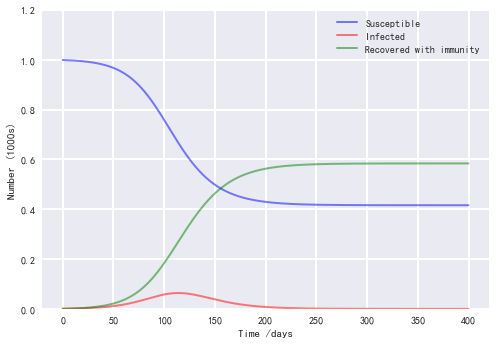

In [24]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.15, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 400, 400)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()